# Project For Applied Artificial Intellence Class 501
Strategic Planning of Cycling Infrastructure Through
Built Environment Analysis and Network Optimization

In [ ]:
! pip install osmnx contextily loguru

In [2]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import contextily as ctx
import geopandas as gpd
import networkx as nx
import osmnx as ox

from loguru import logger
from osmnx import routing
from sklearn.cluster import DBSCAN, KMeans
from sklearn.preprocessing import StandardScaler

In [5]:
def plot_clusters(gdf):
    """
    Visualizes the spatial distribution of clusters from KMeans and
    DBSCAN analysis on a map.

    Each cluster is colored based on the dominant highway type within
    that cluster.

    Args:
        gdf (GeoDataFrame): A GeoDataFrame containing the road network
        edges with 'dbscan_dominant_highway_type' and
        'kmeans_dominant_highway_type' columns.
    """

    logger.info('--- Create the Map Visualization ---')
    # Create two subplots side-by-side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

    logger.info('Plot 1: DBSCAN Clusters colored by dominant highway type')
    gdf.plot(
        column='dbscan_dominant_highway_type', # Color roads by dominant highway type
        categorical=True,       # Treat dominant highway types as distinct categories
        legend=True,            # Show the legend
        linewidth=2,            # Make lines thicker
        ax=ax1,                 # Draw on the first subplot
        cmap='tab10'            # Use a categorical colormap
    )
    ax1.set_title('DBSCAN Clusters by Dominant Highway Type')
    ax1.set_axis_off()
    # Add a basemap for context (requires re-projecting on the fly)
    ctx.add_basemap(ax1, crs=gdf.crs.to_string(), source=ctx.providers.CartoDB.Positron)

    logger.info('Plot 2: KMeans Clusters colored by dominant highway type')
    gdf.plot(
        column='kmeans_dominant_highway_type', # Color roads by dominant highway type
        categorical=True,
        legend=True,
        linewidth=2,
        ax=ax2,
        cmap='tab10' # Use a categorical colormap
    )
    ax2.set_title('KMeans Clusters by Dominant Highway Type')
    ax2.set_axis_off()
    # Add a basemap for context
    ctx.add_basemap(ax2, crs=gdf.crs.to_string(), source=ctx.providers.CartoDB.Positron)
    plt.tight_layout()
    plt.show()


def a_star_path_with_penalty(
    G,
    gdf,
    start_point,
    end_point,
    penalty_factor,
    clusterName='kmeans_combined_cluster'
    ):
    """
    Finds and visualizes the shortest path between two points in a graph,
    applying a penalty to areas not dominated by residential highways
    based on clustering results.

    Args:
        G (networkx.MultiDiGraph): The network graph.
        gdf (GeoDataFrame): A GeoDataFrame containing the graph edges with
        clustering information ('kmeans_combined_cluster' or
        'dbscan_combined_cluster').
        start_point (tuple): A tuple (lat, lon) representing the starting point.
        end_point (tuple): A tuple (lat, lon) representing the ending point.
        penalty_factor (float): The factor by which to increase the cost of
        edges in non-residential dominant clusters.
        clusterName (str, optional): The name of the column in gdf containing
        the cluster labels to use for applying penalties. Defaults to
        'kmeans_combined_cluster'.
    """

    # Reset index
    if isinstance(gdf.index, pd.MultiIndex):
        gdf = gdf.reset_index()

    # Add a new edge attribute for KMeans cost
    for u, v, key, data in G.edges(keys=True, data=True):
        cost = data.get('length', 1)  # Use 'length' as base cost, default to 1 if missing

        # Find the corresponding edge in the gdf
        current_street = gdf[(gdf['u'] == u) & (gdf['v'] == v) & (gdf['key'] == key)]

        if not current_street.empty:
            # Ensure we get the first row if multiple matches exist (shouldn't happen with u,v,key)
            current_street = current_street.iloc[0]
            cluster_label = current_street[clusterName]

            # Get the dominant highway type for this cluster
            if clusterName == 'kmeans_combined_cluster':
              dominant_type = kmeans_dominant_highway.get(cluster_label)
            elif clusterName == 'dbscan_combined_cluster':
              dominant_type = dbscan_dominant_highway.get(cluster_label)
            else:
              raise ValueError(f"Invalid clusterName: {clusterName}")


            # Apply penalty if the dominant type is not 'residential'
            if dominant_type != 'residential':
                cost *= penalty_factor

        # Add the calculated cost as a new edge attribute
        if clusterName == 'kmeans_combined_cluster':
            clusterKey = 'kmeans_cost'
        elif clusterName == 'dbscan_combined_cluster':
            clusterKey = 'dbscan_cost'
        else:
            raise ValueError(f"Invalid clusterName: {clusterName}")

        G.edges[u, v, key][clusterKey] = cost

    # Find the nearest network nodes to the start and end points
    start_node = ox.nearest_nodes(G, start_point[1], start_point[0])
    end_node = ox.nearest_nodes(G, end_point[1], end_point[0])

    try:
        # Find the shortest path using A* algorithm with the new 'kmeans_cost' weight
        path_nodes_kmeans = nx.astar_path(
            G, start_node, end_node, weight=clusterKey
            )

        logger.info("\nRoute found. Prioritizing residential areas according to KMeans.")

        # Convert the list of node IDs (path_nodes_kmeans) to a GeoDataFrame of edges
        route_gdf_kmeans = routing.route_to_gdf(G, path_nodes_kmeans)

        # Create a matplotlib figure and axes object
        fig, ax = plt.subplots(figsize=(12, 12))

        # Plot the route GeoDataFrame
        route_gdf_kmeans.plot(ax=ax, linewidth=4, color='orange')

        # Add a basemap using contextily
        ctx.add_basemap(
            ax,
            crs=route_gdf_kmeans.crs.to_string(),
            source=ctx.providers.OpenStreetMap.Mapnik
            )

        # Add a title
        if clusterName == 'kmeans_combined_cluster':
          ax.set_title("KMeans A* Shortest Path (Prioritizing Residential)")
        else:
          ax.set_title("DBSCAN A* Shortest Path (Prioritizing Residential)")

        # Turn off the axes
        ax.set_axis_off()
    except nx.NetworkXNoPath:
        logger.info("\nNo route could be found under the cluster restrictions.")
    except Exception as e:
        logger.error(f"An error occurred during pathfinding or plotting: {e}")

2025-08-02 16:20:28.216 | INFO     | __main__:<cell line: 0>:10 - Fetching the desired location: Piedmont, California, USA
2025-08-02 16:20:36.175 | INFO     | __main__:<cell line: 0>:12 - Fetched the desired location: Piedmont, California, USA
2025-08-02 16:20:36.176 | INFO     | __main__:<cell line: 0>:13 - Plotting the graph...


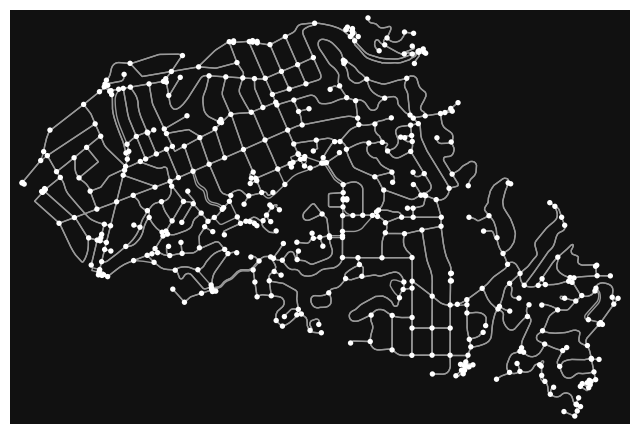

In [6]:
# Increase max query area size (e.g., to 100km * 100km)
# The default is 50km * 50km = 2,500,000,000
#new_max_size = 100000 * 100000  # units are meters
#ox.config(max_query_area_size=new_max_size)

# Choose a location on the level of county. If we go large the graphs become too large to handle efficiently.
location = "Piedmont, California, USA"
transportation_mode = "bike"
# download/model a street network for some city then visualize it
logger.info(f'Fetching the desired location: {location}')
G = ox.graph.graph_from_place(location, network_type=transportation_mode)
logger.info(f'Fetched the desired location: {location}')
logger.info('Plotting the graph...')
fig, ax = ox.plot.plot_graph(G)

In [7]:
logger.info('Get the edges with the information needed to derive a meaningingfull cluster')
edges = ox.graph_to_gdfs(
    G, nodes=False, edges=True, node_geometry=False, fill_edge_geometry=True
    )
# Load the graph into a standard geographic CRS
# Standard CRS: https://en.wikipedia.org/wiki/EPSG_Geodetic_Parameter_Dataset#Common_EPSG_codes
logger.info('Load the graph into a standard geographic CRS using geopandas')
standard_crs = "EPSG:4326"
gdf = gpd.GeoDataFrame(edges, crs=standard_crs)

logger.info('Re-project the data to the correct projected CRS and UTM Zone')
# https://www.usgs.gov/faqs/what-does-term-utm-mean-utm-better-or-more-accurate-latitudelongitude
# Get the UTM CRS for the area
utm_crs = gdf.estimate_utm_crs()
logger.info(f"The estimated UTM CRS for Piedmont, California, USA is: {utm_crs}")
gdf_proj = gdf.to_crs("EPSG:32610")

# We are finding the central point of each individual road line or polygon.
# These central points are then used for clustering, as they provide a single
# coordinate (x, y) to represent the location of each road segment.
logger.info('Find the centroids that represents the geometric center of each edge')
centroids = gdf_proj.geometry.centroid
coords = pd.DataFrame({'x': centroids.x, 'y': centroids.y})

# Use 'highway' column by converting them to strings and use them for clustering
gdf['highway'] = gdf['highway'].apply(lambda x: ', '.join(x) if isinstance(x, list) else x)

# One-Hot Encode the 'highway' column
highway_onehot = pd.get_dummies(gdf['highway'], prefix='highway')
# Combine coordinates and encoded columns into a single feature set
# We reset the index to prevent alignment issues
features = pd.concat([coords.reset_index(drop=True), highway_onehot.reset_index(drop=True)], axis=1)
# Scale the combined features so coordinates don't dominate
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# --- Clustering  code ---
# NOTE: Parameters must be re-tuned as 'eps' is no longer in meters.
db = DBSCAN(eps=1.5, min_samples=5).fit(features_scaled)
gdf['dbscan_combined_cluster'] = db.labels_

kmeans = KMeans(n_clusters=10, random_state=42, n_init='auto').fit(features_scaled)
gdf['kmeans_combined_cluster'] = kmeans.labels_
# The new cluster labels are now in your GeoDataFrame, ready for visualization
logger.info(gdf[['highway', 'kmeans_combined_cluster']].head())

2025-08-02 16:20:36.426 | INFO     | __main__:<cell line: 0>:1 - Get the edges with the information needed to derive a meaningingfull cluster
2025-08-02 16:20:36.450 | INFO     | __main__:<cell line: 0>:7 - Load the graph into a standard geographic CRS using geopandas
2025-08-02 16:20:36.451 | INFO     | __main__:<cell line: 0>:11 - Re-project the data to the correct projected CRS and UTM Zone
2025-08-02 16:20:36.557 | INFO     | __main__:<cell line: 0>:15 - The estimated UTM CRS for Piedmont, California, USA is: EPSG:32610
2025-08-02 16:20:36.562 | INFO     | __main__:<cell line: 0>:21 - Find the centroids that represents the geometric center of each edge
2025-08-02 16:20:36.654 | INFO     | __main__:<cell line: 0>:45 -                            highway  kmeans_combined_cluster
u        v        key                                      
53017091 53064327 0    residential                        1
         53075599 0    residential                        1
53018397 53018399 0    reside

# Next Step
In the above attempt, the methods are not trying to find the areas via clustering using the highway parameter. We used both methods just to test them. Here are the results:  
Both methods are clustering the exact same input data, but they are producing very different outputs because their clustering logic is fundamentally different.

## Key Differences

| Feature             | DBSCAN                                                                 | KMeans                                                                 |
|---------------------|------------------------------------------------------------------------|------------------------------------------------------------------------|
| Input Data          | Acts on the (x, y) coordinates of the road centroids                   | Acts on the exact same (x, y) coordinates of the road centroids       |
| How it Works        | Density-based. Groups points that are closely packed together, marking points in low-density regions as noise. Finds clusters based on a search radius (eps) | Centroid-based. Partitions data into a specified number (k) of clusters, where each point belongs to the cluster with the nearest mean (centroid)                                       |
| Number of Clusters  | Determined automatically based on data density. In this case, it found 25 clusters  | Must be specified beforehand. n_clusters=10, so it was forced to create exactly 10 clusters |
| Cluster Shape       | Can find arbitrarily shaped clusters                                  | Tends to create roughly spherical, evenly-sized clusters              |


THe visualizations perfectly illustrate the difference between the two algorithms:

- **KMeans (Right Image):** This method partitioned your map into 10 large, distinct zones. Because k=10, it divided all the road segments among those 10 groups,
with each group centered around a calculated point. This is useful for tasks like creating 10 service districts or sales territories.

- **DBSCAN (Left Image):** This method acted like a truffle hunter, finding 25 smaller, more granular pockets of high road density.
It didn't try to assign every single road to a large zone. Instead, it identified tight, local groupings.
This is useful for identifying distinct neighborhoods or areas of dense development.

In short, while they both started with the same location data, KMeans answered "How can I split this map into 10 zones?" while DBSCAN answered
"Where are the dense clusters of roads on this map?"

This is not what we want. We want: both methods to cluster the highway column to id where these categories in the map.
We have to a form of one-hot-coding on `highway`

# Task
Generate Python code to visualize the spatial distribution of clusters from KMeans and DBSCAN analysis on a map, where each cluster is colored based on the dominant highway type within that cluster.

## Determine dominant highway type

### Subtask:
For each cluster (in both KMeans and DBSCAN results), identify the most frequent highway type.


**Reasoning**:
Iterate through KMeans and DBSCAN clusters to find the dominant highway type for each and store them in dictionaries.



In [ ]:
logger.info('Find dominant highway type for each KMeans cluster')
kmeans_dominant_highway = {}
for cluster_label in gdf['kmeans_combined_cluster'].unique():
    cluster_gdf = gdf[gdf['kmeans_combined_cluster'] == cluster_label]
    # Use .mode()[0] to get the first mode in case of ties
    dominant_highway = cluster_gdf['highway'].mode()
    if not dominant_highway.empty:
        kmeans_dominant_highway[cluster_label] = dominant_highway[0]
    else:
        kmeans_dominant_highway[cluster_label] = None # Handle empty clusters

logger.info('Find dominant highway type for each DBSCAN cluster')
dbscan_dominant_highway = {}
for cluster_label in gdf['dbscan_combined_cluster'].unique():
    cluster_gdf = gdf[gdf['dbscan_combined_cluster'] == cluster_label]
    dominant_highway = cluster_gdf['highway'].mode()
    if not dominant_highway.empty:
        dbscan_dominant_highway[cluster_label] = dominant_highway[0]
    else:
        dbscan_dominant_highway[cluster_label] = None # Handle empty clusters

logger.info(f"KMeans Dominant Highway Types per Cluster: {kmeans_dominant_highway}")
logger.info("DBSCAN Dominant Highway Types per Cluster:  {dbscan_dominant_highway}")

2025-07-26 19:43:29.703 | INFO     | __main__:<cell line: 0>:1 - Find dominant highway type for each KMeans cluster
2025-07-26 19:43:29.716 | INFO     | __main__:<cell line: 0>:12 - Find dominant highway type for each DBSCAN cluster
2025-07-26 19:43:29.722 | INFO     | __main__:<cell line: 0>:22 - KMeans Dominant Highway Types per Cluster: {np.int32(1): 'residential', np.int32(3): 'tertiary', np.int32(8): 'residential', np.int32(0): 'residential', np.int32(4): 'secondary', np.int32(2): 'service', np.int32(5): 'unclassified', np.int32(9): 'path', np.int32(6): 'tertiary_link', np.int32(7): 'residential, service'}
2025-07-26 19:43:29.723 | INFO     | __main__:<cell line: 0>:23 - DBSCAN Dominant Highway Types per Cluster:  {dbscan_dominant_highway}


## Map cluster labels to dominant highway types

### Subtask:
Create a mapping from the numerical cluster labels to their corresponding dominant highway types.


**Reasoning**:
Map the dominant highway types to the cluster labels in the gdf DataFrame and display the results.



In [ ]:
logger.info('Map KMeans cluster labels to dominant highway types')
gdf['kmeans_dominant_highway_type'] = gdf['kmeans_combined_cluster'].map(kmeans_dominant_highway)

logger.info('Map DBSCAN cluster labels to dominant highway types')
gdf['dbscan_dominant_highway_type'] = gdf['dbscan_combined_cluster'].map(dbscan_dominant_highway)

# Display the first few rows including the new columns
logger.info(gdf[['highway', 'kmeans_combined_cluster', 'kmeans_dominant_highway_type', 'dbscan_combined_cluster', 'dbscan_dominant_highway_type']].head())

2025-07-26 19:43:34.045 | INFO     | __main__:<cell line: 0>:1 - Map KMeans cluster labels to dominant highway types
2025-07-26 19:43:34.047 | INFO     | __main__:<cell line: 0>:4 - Map DBSCAN cluster labels to dominant highway types
2025-07-26 19:43:34.050 | INFO     | __main__:<cell line: 0>:8 -                            highway  kmeans_combined_cluster  \
u        v        key                                         
53017091 53064327 0    residential                        1   
         53075599 0    residential                        1   
53018397 53018399 0    residential                        1   
         53018411 0       tertiary                        3   
         53097980 0       tertiary                        3   

                      kmeans_dominant_highway_type  dbscan_combined_cluster  \
u        v        key                                                         
53017091 53064327 0                    residential                        0   
         53075599 0   

**Reasoning**:
Call the modified plot_clusters function to visualize the clusters colored by dominant highway type.



2025-07-26 19:43:36.748 | INFO     | __main__:plot_clusters:3 - --- Create the Map Visualization ---
2025-07-26 19:43:36.762 | INFO     | __main__:plot_clusters:7 - --- Plot 1: DBSCAN Clusters colored by dominant highway type ---
2025-07-26 19:43:38.259 | INFO     | __main__:plot_clusters:21 - --- Plot 2: KMeans Clusters colored by dominant highway type ---


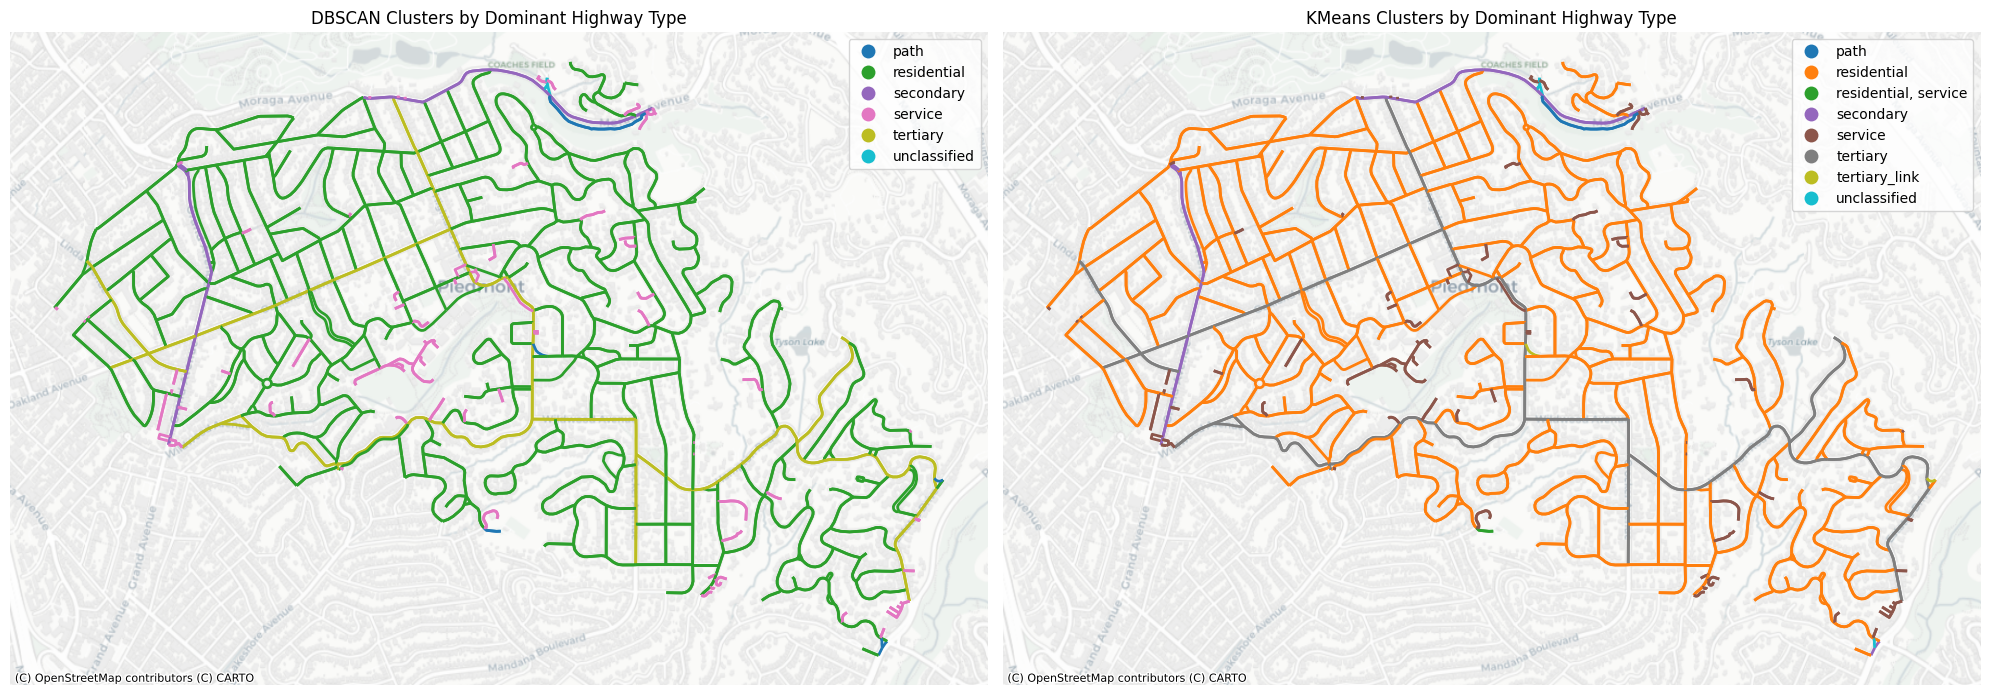

In [ ]:
plot_clusters(gdf)

## Summary:

### Data Analysis Key Findings

*   For KMeans clusters, the dominant highway types were identified for each cluster label. For example, cluster 1 is dominated by 'residential' highways.
*   For DBSCAN clusters, the dominant highway types were also determined. Cluster 0 is dominated by 'residential' highways, while the noise cluster (-1) is dominated by 'path' highways.
*   Two new columns, `kmeans_dominant_highway_type` and `dbscan_dominant_highway_type`, were added to the GeoDataFrame, mapping the cluster labels to their respective dominant highway types.
*   The plotting function was successfully modified to color the clusters on the map based on these newly added dominant highway type columns, using a categorical colormap and displaying a legend.

### Insights or Next Steps

*   The visualizations allow for a spatial understanding of how different highway types are clustered by both algorithms.
*   Comparing the KMeans and DBSCAN maps colored by dominant highway type can provide insights into how each algorithm groups areas with similar road characteristics.


2025-07-26 19:47:22.848 | INFO     | __main__:a_star_path_with_penalty:90 - 
Route found. Prioritizing residential areas according to KMeans.
2025-07-26 19:47:24.213 | INFO     | __main__:a_star_path_with_penalty:90 - 
Route found. Prioritizing residential areas according to KMeans.


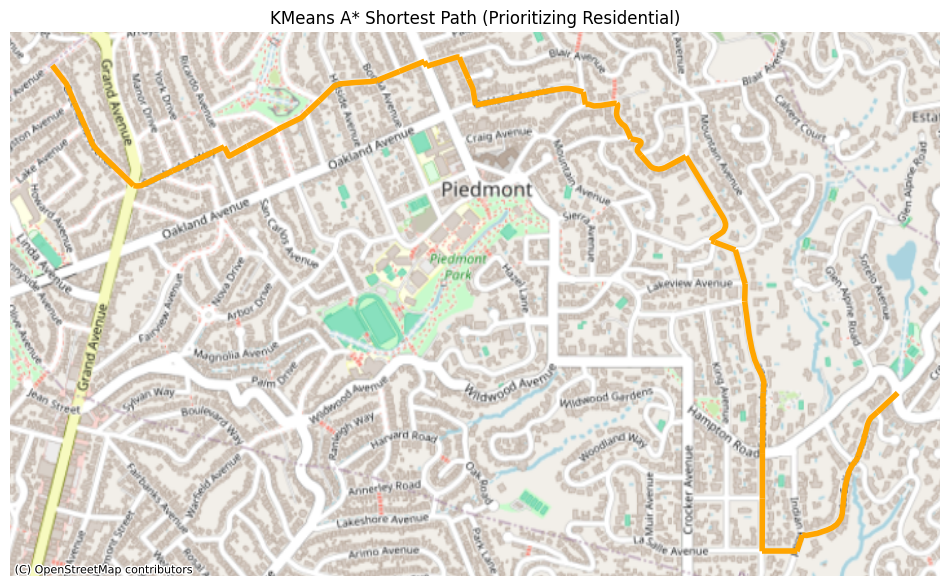

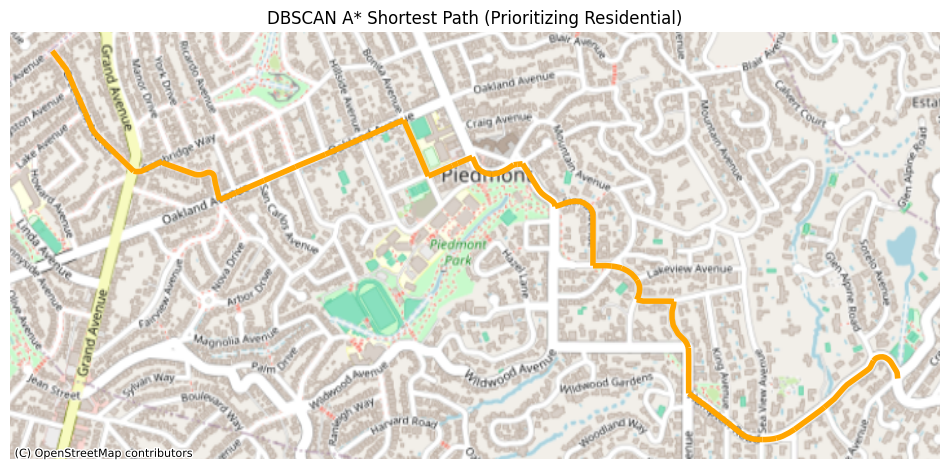

In [ ]:
start_point = (37.827537, -122.245535)
end_point = (37.819275, -122.218562)
penalty_factor = 10
cname = 'kmeans_combined_cluster'
a_star_path_with_penalty(G, gdf, start_point, end_point, penalty_factor, clusterName='kmeans_combined_cluster')
cname = 'dbscan_combined_cluster'
a_star_path_with_penalty(G, gdf, start_point, end_point, penalty_factor, clusterName='dbscan_combined_cluster')